In [8]:
import numpy as np

class Robot: 
    def __init__(self, position): 
        self.position = position
        self.carrying = 0

class Package: 
    def __init__(self, start, start_time, target, deadline, package_id): 
        self.start = start
        self.start_time = start_time
        self.target = target
        self.deadline = deadline
        self.package_id = package_id
        self.status = 'None' # Possible statuses: 'waiting', 'in_transit', 'delivered'

class Environment: 

    def __init__(self, map_file, max_time_steps = 100, n_robots = 5, n_packages=20,
             move_cost=-0.01, delivery_reward=10., delay_reward=1., 
             seed=2025): 
        """ Initializes the simulation environment. :param map_file: Path to the map text file. :param move_cost: Cost incurred when a robot moves (LRUD). :param delivery_reward: Reward for delivering a package on time. """ 
        self.map_file = map_file
        self.grid = self.load_map()
        self.n_rows = len(self.grid)
        self.n_cols = len(self.grid[0]) if self.grid else 0 
        self.move_cost = move_cost 
        self.delivery_reward = delivery_reward 
        self.delay_reward = delay_reward
        self.t = 0 
        self.robots = [] # List of Robot objects.
        self.packages = [] # List of Package objects.
        self.total_reward = 0

        self.n_robots = n_robots
        self.max_time_steps = max_time_steps
        self.n_packages = n_packages

        self.rng = np.random.RandomState(seed)
        self.reset()
        self.done = False
        self.state = None

    def load_map(self):
        """
        Reads the map file and returns a 2D grid.
        Assumes that each line in the file contains numbers separated by space.
        0 indicates free cell and 1 indicates an obstacle.
        """
        grid = []
        with open(self.map_file, 'r') as f:
            for line in f:
                # Strip line breaks and split into numbers
                row = [int(x) for x in line.strip().split(' ')]
                grid.append(row)
        return grid
    
    def is_free_cell(self, position):
        """
        Checks if the cell at the given position is free (0) or occupied (1).
        :param position: Tuple (row, column) to check.
        :return: True if the cell is free, False otherwise.
        """
        r, c = position
        if r < 0 or r >= self.n_rows or c < 0 or c >= self.n_cols:
            return False
        return self.grid[r][c] == 0

    def add_robot(self, position):
        """
        Adds a robot at the given position if the cell is free.
        :param position: Tuple (row, column) for the robot's starting location.
        """
        if self.is_free_cell(position):
            robot = Robot(position)
            self.robots.append(robot)
        else:
            raise ValueError("Invalid robot position: must be on a free cell not occupied by an obstacle or another robot.")

    def reset(self):
        """
        Resets the environment to its initial state.
        Clears all robots and packages, and reinitializes the grid.
        """
        self.t = 0
        self.robots = []
        self.packages = []
        self.total_reward = 0
        self.done = False
        self.state = None

        # Reinitialize the grid
        #self.grid = self.load_map(sel)
        # Add robots and packages
        tmp_grid = np.array(self.grid)
        for i in range(self.n_robots):
            # Randomly select a free cell for the robot
            position, tmp_grid = self.get_random_free_cell(tmp_grid)
            self.add_robot(position)
        
        N = self.n_rows
        list_packages = []
        for i in range(self.n_packages):
            # Randomly select a free cell for the package
            start = self.get_random_free_cell_p()
            while True:
                target = self.get_random_free_cell_p()
                if start != target:
                    break
            
            deadline = self.t + self.rng.randint(N/2, 3*N)
            if i <= min(self.n_robots, 20):
                start_time = 0
            else:
                start_time = self.rng.randint(1, self.max_time_steps)
            list_packages.append((start_time, start, target, deadline))

        list_packages.sort(key=lambda x: x[0])
        for i in range(self.n_packages):
            start_time, start, target, deadline = list_packages[i]
            package_id = i+1
            self.packages.append(Package(start, start_time, target, deadline, package_id))

        return self.get_state()
    
    def get_state(self):
        """
        Returns the current state of the environment.
        The state includes the positions of robots and packages.
        :return: State representation.
        """
        selected_packages = []
        for i in range(len(self.packages)):
            if self.packages[i].start_time == self.t:
                selected_packages.append(self.packages[i])
                self.packages[i].status = 'waiting'

        state = {
            'time_step': self.t,
            'map': self.grid,
            'robots': [(robot.position[0] + 1, robot.position[1] + 1,
                        robot.carrying) for robot in self.robots],
            'packages': [(package.package_id, package.start[0] + 1, package.start[1] + 1, 
                          package.target[0] + 1, package.target[1] + 1, package.start_time, package.deadline) for package in selected_packages]
        }
        return state
        

    def get_random_free_cell_p(self):
        """
        Returns a random free cell in the grid.
        :return: Tuple (row, col) of a free cell.
        """
        free_cells = [(i, j) for i in range(self.n_rows) for j in range(self.n_cols) \
                      if self.grid[i][j] == 0]
        i = self.rng.randint(0, len(free_cells))
        return free_cells[i]


    def get_random_free_cell(self, new_grid):
        """
        Returns a random free cell in the grid.
        :return: Tuple (row, col) of a free cell.
        """
        free_cells = [(i, j) for i in range(self.n_rows) for j in range(self.n_cols) \
                      if new_grid[i][j] == 0]
        i = self.rng.randint(0, len(free_cells))
        new_grid[free_cells[i][0]][free_cells[i][1]] = 1
        return free_cells[i], new_grid

    
    def step(self, actions):
        """
        Advances the simulation by one timestep.
        :param actions: A list where each element is a tuple (move_action, package_action) for a robot.
            move_action: one of 'S', 'L', 'R', 'U', 'D'.
            package_action: '1' (pickup), '2' (drop), or '0' (do nothing).
        :return: The updated state and total accumulated reward.
        """
        r = 0
        if len(actions) != len(self.robots):
            raise ValueError("The number of actions must match the number of robots.")

        #print("Package env: ")
        #print([p.status for p in self.packages])

        # -------- Process Movement --------
        proposed_positions = []
        # For each robot, compute the new position based on the movement action.
        old_pos = {}
        next_pos = {}
        for i, robot in enumerate(self.robots):
            move, pkg_act = actions[i]
            new_pos = self.compute_new_position(robot.position, move)
            # Check if the new position is valid (inside bounds and not an obstacle).
            if not self.valid_position(new_pos):
                new_pos = robot.position  # Invalid moves result in no change.
            proposed_positions.append(new_pos)
            old_pos[robot.position] = i
            next_pos[new_pos] = i

        moved_robots = [0 for _ in range(len(self.robots))]
        computed_moved = [0 for _ in range(len(self.robots))]
        final_positions = [None] * len(self.robots)
        occupied = {}  # Dictionary to record occupied cells.
        while True:
            updated = False
            for i in range(len(self.robots)):
            
                if computed_moved[i] != 0: 
                    continue

                pos = self.robots[i].position
                new_pos = proposed_positions[i]
                can_move = False
                if new_pos not in old_pos:
                    can_move = True
                else:
                    j = old_pos[new_pos]
                    if (j != i) and (computed_moved[j] == 0): # We must wait for the conflict resolve
                        continue
                    # We can decide where the robot can go now
                    can_move = True

                if can_move:
                    # print("Updated: ", i, new_pos)
                    if new_pos not in occupied:
                        occupied[new_pos] = i
                        final_positions[i] = new_pos
                        computed_moved[i] = 1
                        moved_robots[i] = 1
                        updated = True
                    else:
                        new_pos = pos
                        occupied[new_pos] = i
                        final_positions[i] = pos
                        computed_moved[i] = 1
                        moved_robots[i] = 0
                        updated = True

                if updated:
                    break

            if not updated:
                break
        #print("Computed postions: ", final_positions)
        for i in range(len(self.robots)):
            if computed_moved[i] == 0:
                final_positions[i] = self.robots[i].position 
        
        # Update robot positions and apply movement cost when applicable.
        for i, robot in enumerate(self.robots):
            move, pkg_act = actions[i]
            if move in ['L', 'R', 'U', 'D'] and final_positions[i] != robot.position:
                r += self.move_cost
            robot.position = final_positions[i]

        # -------- Process Package Actions --------
        for i, robot in enumerate(self.robots):
            move, pkg_act = actions[i]
            #print(i, move, pkg_act)
            # Pick up action.
            if pkg_act == '1':
                if robot.carrying == 0:
                    # Check for available packages at the current cell.
                    for j in range(len(self.packages)):
                        if self.packages[j].status == 'waiting' and self.packages[j].start == robot.position and self.packages[j].start_time <= self.t:
                            # Pick the package with the smallest package_id.
                            package_id = self.packages[j].package_id
                            robot.carrying = package_id
                            self.packages[j].status = 'in_transit'
                            # print(package_id, 'in transit')
                            break

            # Drop action.
            elif pkg_act == '2':
                if robot.carrying != 0:
                    package_id = robot.carrying
                    target = self.packages[package_id - 1].target
                    # Check if the robot is at the target position.
                    if robot.position == target:
                        # Update package status to delivered.
                        pkg = self.packages[package_id - 1]
                        pkg.status = 'delivered'
                        # Apply reward based on whether the delivery is on time.
                        if self.t <= pkg.deadline:
                            r += self.delivery_reward
                        else:
                            # Example: a reduced reward for late delivery.
                            r += self.delay_reward
                        robot.carrying = 0  
        
        # Increment the simulation timestep.
        self.t += 1

        self.total_reward += r

        done = False
        infos = {}
        if self.check_terminate():
            done = True
            infos['total_reward'] = self.total_reward
            infos['total_time_steps'] = self.t

        return self.get_state(), r, done, infos
    
    def check_terminate(self):
        if self.t == self.max_time_steps:
            return True
        
        for p in self.packages:
            if p.status != 'delivered':
                return False
            
        return True

    def compute_new_position(self, position, move):
        """
        Computes the intended new position for a robot given its current position and move command.
        """
        r, c = position
        if move == 'S':
            return (r, c)
        elif move == 'L':
            return (r, c - 1)
        elif move == 'R':
            return (r, c + 1)
        elif move == 'U':
            return (r - 1, c)
        elif move == 'D':
            return (r + 1, c)
        else:
            return (r, c)

    def valid_position(self, pos):
        """
        Checks if the new position is within the grid and not an obstacle.
        """
        r, c = pos
        if r < 0 or r >= self.n_rows or c < 0 or c >= self.n_cols:
            return False
        if self.grid[r][c] == 1:
            return False
        return True

    def render(self):
        """
        A simple text-based rendering of the map showing obstacles and robot positions.
        Obstacles are represented by 1, free cells by 0, and robots by 'R'.
        """
        # Make a deep copy of the grid
        grid_copy = [row[:] for row in self.grid]
        for i, robot in enumerate(self.robots):
            r, c = robot.position
            grid_copy[r][c] = 'R%i'%i
        for row in grid_copy:
            print('\t'.join(str(cell) for cell in row))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.optim.lr_scheduler as lr_scheduler

In [12]:
class Cnn(nn.Module):
    def __init__(self, input_channels=1, hidden_size=128):
        super(Cnn, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Adaptive pooling to get fixed output size regardless of input dimensions
        self.adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
        
        # Fixed feature size after adaptive pooling
        feature_size = 128 * 2 * 2  # 128 channels, 2x2 after adaptive pooling
        self.fc = nn.Linear(feature_size, hidden_size)
        
    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # Third convolutional block
        x = F.relu(self.conv3(x))
        
        # Adaptive pooling to fixed size (2,2)
        x = self.adaptive_pool(x)
        
        # Flatten and feed through fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
class SharedNetwork(nn.Module):
    def __init__(self, n_robots, pkg_hidden=64, robot_hidden=64, out_dim=128):
        super().__init__()
        self.n_robots = n_robots
        
        # Tăng kích thước ẩn để mô hình mạnh hơn
        self.robot_hidden = robot_hidden
        self.pkg_hidden = pkg_hidden
        
        # Mạng sâu hơn cho robot_tensor
        self.robot_fc = nn.Sequential(
            nn.Linear(3, robot_hidden),  # Từ 3 đặc trưng (row, col, carrying status)
            nn.ReLU(),
            nn.Dropout(0.2),  # Giảm overfitting
            nn.Linear(robot_hidden, robot_hidden * 2),  # Tăng chiều sâu
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(robot_hidden * 2, robot_hidden)  # Trở về kích thước robot_hidden
        )
        
        # Mạng sâu hơn cho package_tensor
        self.pkg_fc = nn.Sequential(
            nn.Linear(8, pkg_hidden),  # Từ 8 đặc trưng mỗi gói
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(pkg_hidden, pkg_hidden * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(pkg_hidden * 2, pkg_hidden)
        )
        
        # Xử lý time_step
        self.time_fc = nn.Linear(1, 32)  # Biến time_step thành vector đặc trưng
        
        # Attention mechanism cho package_tensor
        self.attention = nn.MultiheadAttention(embed_dim=pkg_hidden, num_heads=4, dropout=0.1)
        
        # Lớp fully connected cuối cùng để kết hợp tất cả đặc trưng
        input_size = n_robots * robot_hidden + 128 * pkg_hidden + 32  # robot + package + time
        self.final_fc = nn.Sequential(
            nn.Linear(input_size, input_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_size // 2, out_dim),
            nn.ReLU()
        )
        
    def forward(self, robot_tensor, package_tensor, time_step):
        # Xử lý robot_tensor: [n_robots, 3] -> [n_robots, robot_hidden]
        robot_features = self.robot_fc(robot_tensor)  # [n_robots, robot_hidden]
        robot_features = robot_features.view(-1)  # [n_robots * robot_hidden]
        
        # Xử lý package_tensor: [128, 8] -> [128, pkg_hidden]
        pkg_features = self.pkg_fc(package_tensor)  # [128, pkg_hidden]
        
        # Áp dụng attention cho package_tensor
        pkg_features = pkg_features.unsqueeze(1)  # [128, 1, pkg_hidden] cho attention
        attn_output, _ = self.attention(pkg_features, pkg_features, pkg_features)  # [128, 1, pkg_hidden]
        pkg_features = attn_output.squeeze(1)  # [128, pkg_hidden]
        pkg_features = pkg_features.view(-1)  # [128 * pkg_hidden]
        
        # Xử lý time_step
        if time_step.dim() == 0:
            time_step = time_step.unsqueeze(0)  # [1]
        time_features = F.relu(self.time_fc(time_step.unsqueeze(-1)))  # [1, 32]
        time_features = time_features.view(-1)  # [32]
        
        # Kết hợp các đặc trưng
        combined = torch.cat([robot_features, pkg_features, time_features], dim=0)  # [n_robots * robot_hidden + 128 * pkg_hidden + 32]
        
        # Tạo vector đặc trưng chia sẻ
        shared_features = self.final_fc(combined)  # [out_dim]
        shared_features = shared_features.unsqueeze(0)  # [1, out_dim]
        return shared_features
        

class PolicyNetwork(nn.Module):
    def __init__(self, hidden_size=128, move_output_size=5, package_output_size=3, shared_dim=128):
        super(PolicyNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.shared_dim = shared_dim
        
        self.cnn = Cnn(input_channels=1, hidden_size=hidden_size)
        
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=4, dropout=0.1)
        
        self.combine_fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.LayerNorm(hidden_size * 4),
            nn.Dropout(0.3),
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.ReLU(),
            nn.LayerNorm(hidden_size * 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.LayerNorm(hidden_size),
            nn.Dropout(0.3)
        )
        
        self.move_head = nn.Linear(hidden_size, move_output_size)
        self.package_head = nn.Linear(hidden_size, package_output_size)
    
    def forward(self, agent_x, shared_x):
        if len(agent_x.shape) == 2:
            x = agent_x.unsqueeze(0).unsqueeze(0)
        else:
            x = agent_x
        
        agent_features = self.cnn(x)
        
        if shared_x.dim() == 1:
            shared_x = shared_x.unsqueeze(0)
        
        combined_features = torch.stack([agent_features, shared_x], dim=0)
        attn_output, _ = self.attention(combined_features, combined_features, combined_features)
        combined = attn_output.sum(dim=0)
        
        x = self.combine_fc(combined)
        
        move_probs = F.softmax(self.move_head(x), dim=-1)
        package_probs = F.softmax(self.package_head(x), dim=-1)
        return move_probs, package_probs

class Agent:
    def __init__(self, hidden_size=128, learning_rate=0.001, gamma=0.99):
        self.policy = PolicyNetwork(hidden_size, 5, 3, 128).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.gamma = gamma
        
        self.saved_log_probs_move = []
        self.saved_log_probs_package = []
        self.individual_rewards = []
        self.team_rewards = []
        
    def select_action(self, state, shared_features):
        move_probs, package_probs = self.policy(state, shared_features)
        
        move_dist = Categorical(move_probs)
        package_dist = Categorical(package_probs)
        
        move = move_dist.sample()
        pkg = package_dist.sample()
        
        self.saved_log_probs_move.append(move_dist.log_prob(move))
        self.saved_log_probs_package.append(package_dist.log_prob(pkg))
        
        return move.item(), pkg.item()
    
    def finish_episode(self, team_reward_weight=0.5):
        # Return early if no experience to learn from
        if not self.individual_rewards:
            return
            
        R = 0
        returns = []
        
        # Calculate discounted returns
        for ind_r, team_r in zip(reversed(self.individual_rewards), reversed(self.team_rewards)):
            r = (1-team_reward_weight)*ind_r + team_reward_weight*team_r
            R = r + self.gamma * R
            returns.insert(0, R)
            
        returns = torch.tensor(returns).to(device)
        
        # Normalize returns (helps with training stability)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)
            
        # Calculate loss
        policy_loss = []
        for lp_m, lp_p, R in zip(self.saved_log_probs_move, self.saved_log_probs_package, returns):
            policy_loss.append(-(lp_m + lp_p) * R)
            
        if policy_loss:
            policy_loss = torch.stack(policy_loss).sum()
            
            # Perform backpropagation
            self.optimizer.zero_grad()
            policy_loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
        # Clear memory
        self.saved_log_probs_move = []
        self.saved_log_probs_package = []
        self.individual_rewards = []
        self.team_rewards = []

class Agents:
    def __init__(self, input_size=64, hidden_size=128, learning_rate=0.001, gamma=0.99, team_reward_weight=0.6):
        self.n_robots = 0
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.map_fc_size = 64
        self.gamma = gamma
        self.team_reward_weight = team_reward_weight

        self.move_actions = ['S','L','R','U','D']  # Stay, Left, Right, Up, Down
        self.package_actions = ['0','1','2']  # No action, Pick up, Drop off
        self.exploration_decay = 0.99
        self.min_exploration = 0.05  # Don't go below this exploration rate
        self.learning_rate = learning_rate

        self.shared_extractor = None
        self.shared_optimizer = None
        self.training = True
        self.agents = []
        self.packages = []
        self.packages_free = []
        self.robots_target = []
        
        # Add training metrics
        self.episode_rewards = []
        self.episode_deliveries = []
        self.episode_late_deliveries = []

    def init_agents(self, state):
        self.n_robots = len(state['robots'])
        self.delivered_packages = 0
        self.delivered_packages_dl = 0
        self.exploration_rate = 0.2  # Higher initial exploration
        
        if self.shared_extractor is None:
            self.shared_extractor = SharedNetwork(self.n_robots).to(device)
            self.shared_optimizer = optim.Adam(self.shared_extractor.parameters(), lr=self.learning_rate)
        
        if not self.agents:
            self.agents = [Agent(self.hidden_size, self.learning_rate, self.gamma)
                           for _ in range(self.n_robots)]

        self.robots_target = ['free'] * self.n_robots
        self.packages = [(p[0], p[1]-1, p[2]-1, p[3]-1, p[4]-1, p[5], p[6]) for p in state['packages']]
        self.packages_free = [True] * len(self.packages)

    def set_team_reward_weight(self, weight):
        """Cập nhật team_reward_weight."""
        self.team_reward_weight = weight

    def get_global_state_representation(self, state):
        robot_data = []
        for robot in state['robots']:
            robot_data.append([
                robot[0] - 1,  # row (0-based)
                robot[1] - 1,  # col (0-based)
                robot[2]       # carrying status
            ])
        robot_tensor = torch.tensor(robot_data, dtype=torch.float32).to(device)
        
        # Package tensor
        package_data = []
        current_time = state['time_step']
        for pkg in self.packages:
            remaining_time = max(0, pkg[6] - current_time)  # Thời gian còn lại đến deadline
            package_data.append([
                pkg[0],  # package_id
                pkg[1],  # start_row (0-based)
                pkg[2],  # start_col (0-based)
                pkg[3],  # target_row (0-based)
                pkg[4],  # target_col (0-based)
                pkg[5],  # start_time
                pkg[6],  # deadline
                remaining_time
            ])

        while len(package_data) < 128:
            package_data.append([0] * 8)  # Điền 0 cho các gói hàng không tồn tại
        package_tensor = torch.tensor(package_data[:128], dtype=torch.float32).to(device)  # (128, 8)
        
        # Time step
        time_step = torch.tensor(float(current_time), dtype=torch.float32).to(device) 
        return robot_tensor, package_tensor, time_step
    
    def get_agent_state_representation(self, state, robot_idx):
        # Initialize tensor from map
        agent_x = torch.tensor(state['map'], dtype=torch.float32).to(device)  # (H, W)

        H, W = agent_x.shape
        
        # Mark current agent position
        current_robot = state['robots'][robot_idx]
        row, col, carrying = current_robot[0] - 1, current_robot[1] - 1, current_robot[2]
        agent_x[row, col] = -1  # Current agent position
        
        # Mark other agents
        for i, robot in enumerate(state['robots']):
            if i != robot_idx:
                r, c = robot[0] - 1, robot[1] - 1
                agent_x[r, c] = 2  # Other agent positions
        
        return agent_x

    def calculate_distance(self, pos1, pos2):
        """Calculate Manhattan distance between two positions"""
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def get_actions(self, state):
        if not self.agents:
            self.init_agents(state)
        
        # Get shared features
        robot_tensor, package_tensor, time_step = self.get_global_state_representation(state)
        with torch.no_grad():
            sf = self.shared_extractor(robot_tensor, package_tensor, time_step)

        actions = []
        for i in range(self.n_robots):
            if self.training and np.random.rand() < self.exploration_rate:
                # Exploration: choose random action
                move_idx = np.random.choice(range(len(self.move_actions)))
                pkg_idx = np.random.choice(range(len(self.package_actions)))
                actions.append((move_idx, pkg_idx))
            else:
                # Exploitation: use learned policy
                af = self.get_agent_state_representation(state, i)
                move_idx, pkg_idx = self.agents[i].select_action(af, sf)
                actions.append((move_idx, pkg_idx))
            
        if self.training:
            self.exploration_rate = max(self.min_exploration, self.exploration_rate * self.exploration_decay)
            
        # Convert indices to actual actions
        return [(self.move_actions[a[0]], self.package_actions[a[1]]) for a in actions]

    def update_rewards(self, reward, state=None, new_state=None, actions=None):
        if not self.training or actions is None:
            return
            
        for i, agent in enumerate(self.agents):
            # Start with environment reward for teamwork component
            ind_r = 0  # Individual reward starts at 0
            
            # Get robot positions
            new_robot = new_state['robots'][i]
            prev_robot = state['robots'][i]
            
            # Check if agent moved
            prev_row, prev_col = prev_robot[0] - 1, prev_robot[1] - 1
            new_row, new_col = new_robot[0] - 1, new_robot[1] - 1
            
            # Movement penalty/reward
            moved = (prev_row != new_row or prev_col != new_col)
            if not moved:
                ind_r -= 0.02  # Penalize staying in place
            else:
                ind_r += 0.0  # Small reward for moving
            
            # Package handling rewards
            if prev_robot[2] == 0:  # Not carrying a package  
                if actions[i][1] == '1':  # Attempt to pick up
                    if new_robot[2] != 0:  # Successfully picked up
                        package_id = new_robot[2]
                        for pkg in self.packages:
                            if pkg[0] == package_id:
                                time_to_deadline = pkg[6] - state['time_step']
                                if time_to_deadline >= 0:
                                    ind_r += 100  # Basic pickup reward
                                    ind_r += min(time_to_deadline * 0.1, 1.0)  # Bonus for early pickup
                                else:
                                    ind_r += 50  # Smaller reward for late pickup
                                    
            elif prev_robot[2] != 0:  # Carrying a package
                package_id = prev_robot[2]
                target_row, target_col = None, None
                time_to_deadline = None
                
                # Find package info
                for pkg in self.packages:
                    if pkg[0] == package_id:
                        target_row, target_col = pkg[3], pkg[4]  # Target position
                        time_to_deadline = pkg[6] - state['time_step']
                        break
                        
                if target_row is not None and target_col is not None:
                    # Convert coordinates from 1-based to 0-based
                    target_row, target_col = target_row - 1, target_col - 1
                    
                    # Calculate Manhattan distances
                    prev_distance = abs(prev_row - target_row) + abs(prev_col - target_col)
                    new_distance = abs(new_row - target_row) + abs(new_col - target_col)
                    
                    # Reward for moving toward target, penalize moving away
                    if new_distance < prev_distance:
                        ind_r += 0.01
                    elif new_distance > prev_distance:
                        ind_r -= 0.01
                    
                # Handle package drop-off
                if actions[i][1] == '2':  # Attempt to drop off
                    if new_robot[2] == 0:  # Successfully dropped off
                        if time_to_deadline is not None:
                            if time_to_deadline >= 0:
                                ind_r += 200  # Base reward for on-time delivery
                                ind_r += min(time_to_deadline * 0.5, 1.0)  # Bonus for early delivery
                                self.delivered_packages += 1
                            else:
                                ind_r += 100  # Small reward for late delivery
                                self.delivered_packages_dl += 1
                        self.packages = [pkg for pkg in self.packages if pkg[0] != prev_robot[2]]
            
            # Store rewards
            agent.individual_rewards.append(ind_r)
            agent.team_rewards.append(reward / self.n_robots)

    def update_packages(self, state):
        self.packages += [(p[0], p[1]-1, p[2]-1, p[3]-1, p[4]-1, p[5], p[6]) for p in state['packages']]

    def train(self):
        if self.training:
            # Train individual agents
            for agent in self.agents:
                agent.finish_episode(self.team_reward_weight)
                
            # Train shared feature extractor
            if self.shared_extractor and self.shared_optimizer:
                self.shared_optimizer.step()
                
    def end_episode(self, total_reward):
        # Store episode metrics
        self.episode_rewards.append(total_reward)
        self.episode_deliveries.append(self.delivered_packages)
        self.episode_late_deliveries.append(self.delivered_packages_dl)
        
        # Print detailed metrics every few episodes
        if len(self.episode_rewards) % 10 == 0:
            avg_reward = sum(self.episode_rewards[-10:]) / 10
            avg_deliveries = sum(self.episode_deliveries[-10:]) / 10
            print(f"Last 10 episodes - Avg Reward: {avg_reward:.2f}, Avg Deliveries: {avg_deliveries:.1f}")
            print(f"Current exploration rate: {self.exploration_rate:.4f}")

    def save_models(self, prefix="reinforce_model_"):
        for i, agent in enumerate(self.agents):
            torch.save(agent.policy.state_dict(), f"{prefix}{i}.pt")
        if self.shared_extractor:
            torch.save(self.shared_extractor.state_dict(), f"{prefix}shared.pt")

    def load_models(self, prefix="reinforce_model_"):
        for i, agent in enumerate(self.agents):
            try:
                agent.policy.load_state_dict(torch.load(f"{prefix}{i}.pt"))
                agent.policy.eval()
            except FileNotFoundError:
                print(f"Model {prefix}{i}.pt not found, skipping.")
        if self.shared_extractor:
            try:
                self.shared_extractor.load_state_dict(torch.load(f"{prefix}shared.pt"))
                self.shared_extractor.eval()
            except FileNotFoundError:
                print(f"Shared model {prefix}shared.pt not found, skipping.")

In [14]:
env = Environment('/kaggle/input/map-for-marl-delivery-problems/map1.txt', max_time_steps=100, n_robots=10, n_packages=100)
agents = Agents(input_size=1024, hidden_size=128, team_reward_weight=0.5)

best_reward = float('-inf')
rewards_history = []
on_time = []
late = []

total_episodes = 100
start_weight = 0.2
end_weight = 0.8

for ep in range(total_episodes):
    team_reward_weight = start_weight + (end_weight - start_weight) * (ep / total_episodes)
    agents.set_team_reward_weight(team_reward_weight)
    
    state = env.reset()
    agents.init_agents(state)
    done = False
    nstep = 0

    
    while not done:
        acts = agents.get_actions(state)
        new_state, r, done, infos = env.step(acts)
        agents.update_rewards(r, state, new_state, acts)
        state = new_state
        agents.update_packages(state)
        
        # Train periodically during episode
        if nstep % 10 == 0:
            agents.train()
        
        nstep += 1
    
    # Final training step to use last experiences
    agents.train()
    
    # Store episode results
    total_reward = infos['total_reward']
    agents.end_episode(total_reward)
    rewards_history.append(total_reward)
    on_time.append(agents.delivered_packages)
    late.append(agents.delivered_packages_dl)
    
    # Save best model
    if total_reward > best_reward:
        best_reward = total_reward
        agents.save_models(prefix="best_agent")
    
    # Save checkpoint models periodically
    if ep % 100 == 0:
        agents.save_models(prefix=f"checkpoint_ep{ep}_")
    
    print(f"Ep {ep}, Reward {total_reward:.2f}, Delivered on-time {agents.delivered_packages}, Delivered late {agents.delivered_packages_dl}")

Ep 0, Reward 5.36, Delivered on-time 1, Delivered late 1
Ep 1, Reward -4.40, Delivered on-time 0, Delivered late 1
Ep 2, Reward -2.20, Delivered on-time 0, Delivered late 3
Ep 3, Reward 4.95, Delivered on-time 1, Delivered late 0
Ep 4, Reward -3.07, Delivered on-time 0, Delivered late 2
Ep 5, Reward -5.18, Delivered on-time 0, Delivered late 0
Ep 6, Reward -2.88, Delivered on-time 0, Delivered late 2
Ep 7, Reward -4.07, Delivered on-time 0, Delivered late 1
Ep 8, Reward 4.85, Delivered on-time 1, Delivered late 0
Last 10 episodes - Avg Reward: -0.02, Avg Deliveries: 0.4
Current exploration rate: 0.0732
Ep 9, Reward 6.45, Delivered on-time 1, Delivered late 2
Ep 10, Reward -4.31, Delivered on-time 0, Delivered late 1
Ep 11, Reward 8.86, Delivered on-time 1, Delivered late 4
Ep 12, Reward -3.38, Delivered on-time 0, Delivered late 1
Ep 13, Reward -5.23, Delivered on-time 0, Delivered late 0
Ep 14, Reward -4.84, Delivered on-time 0, Delivered late 0
Ep 15, Reward -4.23, Delivered on-time 

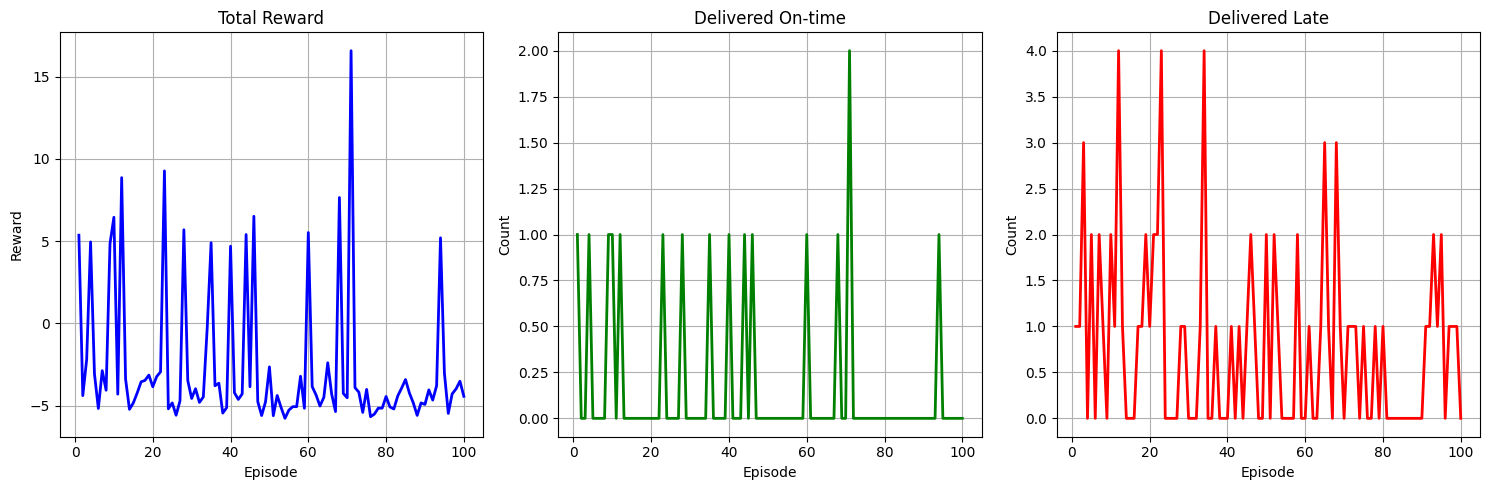

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Tạo danh sách episodes dựa trên độ dài của episode_rewards
episodes = list(range(1, len(rewards_history) + 1))

# Tạo figure với ba subplots
plt.figure(figsize=(15, 5))

# Subplot 1: Total Reward
plt.subplot(1, 3, 1)
plt.plot(episodes, rewards_history, color='blue', linewidth=2)
plt.title('Total Reward', fontsize=12)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('Reward', fontsize=10)
plt.grid(True)

# Subplot 2: Delivered On-time
plt.subplot(1, 3, 2)
plt.plot(episodes, on_time, color='green', linewidth=2)
plt.title('Delivered On-time', fontsize=12)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True)

# Subplot 3: Delivered Late
plt.subplot(1, 3, 3)
plt.plot(episodes, late, color='red', linewidth=2)
plt.title('Delivered Late', fontsize=12)
plt.xlabel('Episode', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid(True)

# Điều chỉnh bố cục để tránh chồng lấn
plt.tight_layout()
plt.show()

In [17]:
import shutil
import os
import zipfile

shutil.make_archive("output", "zip", "/kaggle/working/")

'/kaggle/working/output.zip'